In [1]:
import torch
import numpy as np
import torch.nn as nn
import dynamic_selection as ds
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torchmetrics import Accuracy
from dynamic_selection.utils import Flatten
from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection

In [2]:
# Load dataset.
mnist_dataset = MNIST('/tmp/mnist/', download=True, train=True,
                      transform=transforms.Compose([transforms.ToTensor(), Flatten()]))
test_dataset = MNIST('/tmp/mnist/', download=True, train=False,
                     transform=transforms.Compose([transforms.ToTensor(), Flatten()]))
d_in = 784
d_out = 10

# Split into train/val.
np.random.seed(0)
val_inds = np.sort(np.random.choice(len(mnist_dataset), size=10000, replace=False))
train_inds = np.setdiff1d(np.arange(len(mnist_dataset)), val_inds)
train_dataset = torch.utils.data.Subset(mnist_dataset, train_inds)
val_dataset = torch.utils.data.Subset(mnist_dataset, val_inds)

In [3]:
# Prepare networks.
hidden = 512
dropout = 0.3

predictor = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out))

selector = nn.Sequential(
    nn.Linear(2 * d_in, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_in))

In [4]:
# Pretrain predictor
mask_layer = ds.utils.MaskLayer(append=True)
pretrain = MaskingPretrainer(predictor, mask_layer).cuda()
pretrain.fit(
    train_dataset,
    val_dataset,
    mbsize=128,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

--------Epoch 1--------
Val loss = 0.6031

--------Epoch 2--------
Val loss = 0.5232

--------Epoch 3--------
Val loss = 0.4643

--------Epoch 4--------
Val loss = 0.4211

--------Epoch 5--------
Val loss = 0.4036

--------Epoch 6--------
Val loss = 0.3925

--------Epoch 7--------
Val loss = 0.3609

--------Epoch 8--------
Val loss = 0.3497

--------Epoch 9--------
Val loss = 0.3600

--------Epoch 10--------
Val loss = 0.3505

--------Epoch 11--------
Val loss = 0.3267

--------Epoch 12--------
Val loss = 0.3306

--------Epoch 13--------
Val loss = 0.3233

--------Epoch 14--------
Val loss = 0.3280

--------Epoch 15--------
Val loss = 0.3289

--------Epoch 16--------
Val loss = 0.3054

--------Epoch 17--------
Val loss = 0.3146

--------Epoch 18--------
Val loss = 0.3045

--------Epoch 19--------
Val loss = 0.3136

--------Epoch 20--------
Val loss = 0.2995

--------Epoch 21--------
Val loss = 0.2951

--------Epoch 22--------
Val loss = 0.3038

--------Epoch 23--------
Val loss = 0.286

In [ ]:
# Train selector and predictor jointly.
gdfs = GreedyDynamicSelection(selector, predictor, mask_layer).cuda()
gdfs.fit(
    train_dataset,
    val_dataset,
    mbsize=128,
    lr=1e-3,
    nepochs=250,
    max_features=50,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.4773, Zero-temp loss = 0.5299

--------Epoch 2 (2 total)--------
Val loss = 0.4437, Zero-temp loss = 0.5103

--------Epoch 3 (3 total)--------
Val loss = 0.4073, Zero-temp loss = 0.4821

--------Epoch 4 (4 total)--------
Val loss = 0.3908, Zero-temp loss = 0.4789

--------Epoch 5 (5 total)--------
Val loss = 0.3730, Zero-temp loss = 0.4721

--------Epoch 6 (6 total)--------
Val loss = 0.3571, Zero-temp loss = 0.4630

--------Epoch 7 (7 total)--------
Val loss = 0.3484, Zero-temp loss = 0.4617

--------Epoch 8 (8 total)--------
Val loss = 0.3362, Zero-temp loss = 0.4580

--------Epoch 9 (9 total)--------
Val loss = 0.3321, Zero-temp loss = 0.4624

--------Epoch 10 (10 total)--------
Val loss = 0.3288, Zero-temp loss = 0.4681

--------Epoch 11 (11 total)--------
Val loss = 0.3174, Zero-temp loss = 0.4592

--------Epoch 12 (12 total)--------
Val loss = 0.3028, Zero-temp loss = 0.4521

--------Epoch 13 (13

# Evaluate performance

- Top-1 accuracy improves quickly with the feature budget
- Performance can usually be improved by increasing the `patience` parameter, or by using more temperature steps (`temp_steps`)

In [14]:
# Setup.
num_features = list(range(5, 35, 5)) + list(range(40, 110, 10))
acc_list = []
acc_metric = Accuracy()

# Evaluate.
for num in num_features:
    acc = gdfs.evaluate(test_dataset, num, acc_metric, 1024)
    acc_list.append(acc)
    print(f'Num = {num}, Acc = {100*acc:.2f}')

Num = 5, Acc = 69.61
Num = 10, Acc = 87.21
Num = 15, Acc = 92.72
Num = 20, Acc = 94.69
Num = 25, Acc = 95.83
Num = 30, Acc = 96.42
Num = 40, Acc = 97.31
Num = 50, Acc = 97.31
Num = 60, Acc = 97.39
Num = 70, Acc = 97.55
Num = 80, Acc = 97.61
Num = 90, Acc = 97.54
Num = 100, Acc = 97.36


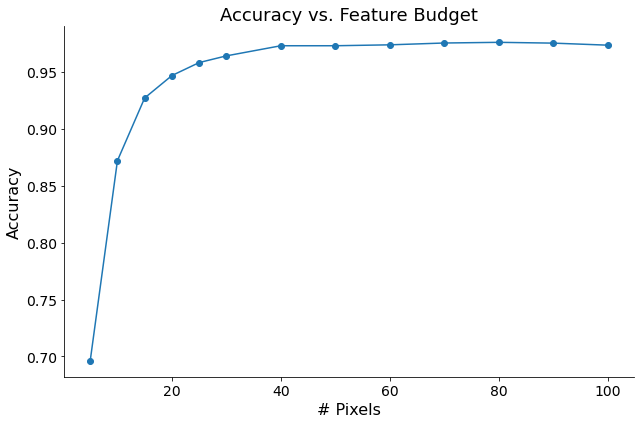

In [15]:
# Plot results
plt.figure(figsize=(9, 6))

# Accuracy
plt.plot(num_features, acc_list, marker='o')
plt.xlabel('# Pixels', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy vs. Feature Budget', fontsize=18)
plt.tick_params(labelsize=14)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

# Plot frequent selections

In [32]:
# Generate selections for 25 pixels
num_features = 25
x, y = ds.data.get_xy(test_dataset)
pred, x_masked, m = gdfs(x.cuda(), max_features=num_features)

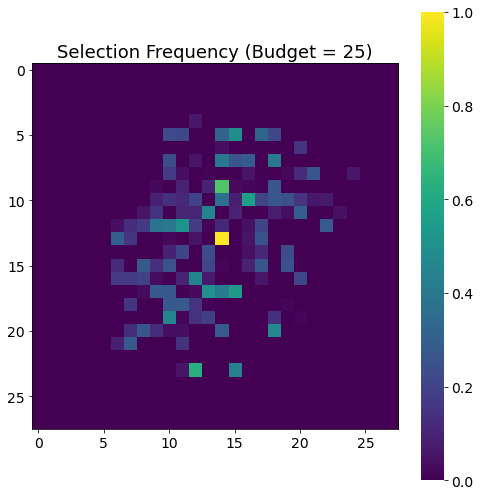

In [33]:
# Plot selection frequency.
plt.figure(figsize=(7, 7))

plt.imshow(m.mean(dim=0).cpu().data.numpy().reshape(28, 28))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.outline.set_visible(False)
plt.tick_params(labelsize=14)
plt.title('Selection Frequency (Budget = 25)', fontsize=18)

plt.tight_layout()
plt.show()